In [1]:
from exod.utils.path import data
from exod.utils.logger import logger
from exod.pre_processing.data_loader import DataLoader
from exod.xmm.event_list import EventList
from exod.xmm.observation import Observation
from exod.utils.path import read_observation_ids
from exod.processing.bayesian_computations import PrecomputeBayesLimits
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA
from exod.utils.logger import logger
from exod.utils.plotting import compare_images
from exod.xmm.observation import Observation

import numpy as np
import matplotlib.pyplot as plt
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA
from skimage.draw import disk
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.interpolate import interp1d

import cmasher
from matplotlib.colors import LogNorm
from exod.utils.plotting import cmap_image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from exod.processing.background_inference import mask_known_sources, calc_background_template, calc_source_template, calc_cube_mu

In [2]:
obsid='0911791101'
size_arcsec=20
time_interval=50
gti_only=False
remove_partial_ccd_frames=True
gti_threshold=1.5
min_energy=0.2
max_energy=10.0
clobber=False
precomputed_bayes_limit=PrecomputeBayesLimits(threshold_sigma=3)

In [3]:
precomputed_bayes_limit.load()
observation = Observation(obsid)
observation.get_files()
observation.get_events_overlapping_subsets()
img = observation.images[0]
img.read(wcs_only=True)
wcs = img.wcs
for ind_exp, subset_overlapping_exposures in enumerate(observation.events_overlapping_subsets):
    event_list = EventList.from_event_lists(subset_overlapping_exposures)
    # event_list = observation.events_processed_pn[0]
    # event_list.read()
    dl = DataLoader(event_list=event_list, time_interval=time_interval, size_arcsec=size_arcsec,
                    gti_only=gti_only, min_energy=min_energy, max_energy=max_energy)
    dl.run()
    data_cube = dl.data_cube


2024-05-21 09:33:05,085 - INFO - observation.py:get_files - Getting Observation('0911791101') Files...
2024-05-21 09:33:05,560 - INFO - event_list.py:remove_hot_pixels - Removed Hot Pixels EMOS2 | Pre: 302847 Post: 302784 (-63)
2024-05-21 09:33:05,668 - INFO - event_list.py:remove_bad_rows - Removing bad PN rows Struder et al. 2001b
2024-05-21 09:33:05,713 - INFO - event_list.py:remove_borders - Removing Borders: EPN PrimeFullWindow
2024-05-21 09:33:08,441 - INFO - event_list.py:remove_hot_pixels - Removed Hot Pixels EPN | Pre: 1601384 Post: 1590862 (-10522)
2024-05-21 09:33:08,922 - INFO - event_list.py:remove_hot_pixels - Removed Hot Pixels EMOS1 | Pre: 304016 Post: 303217 (-799)
2024-05-21 09:33:08,922 - INFO - observation.py:get_overlapping_eventlist_subsets - Found 1 overlapping subsets.
2024-05-21 09:33:08,969 - INFO - data_loader.py:get_high_energy_lc - min_energy_he = 10.0 max_energy_he = 12.0 time_interval_gti = 50
2024-05-21 09:33:08,977 - INFO - bti.py:get_bti - Curve Starte

2024-05-21 09:46:24,890 - INFO - background_inference.py:mask_known_sources - OBSMLI file: /home/nkhan/EXOD2/data/raw/0911791101/P0911791101EPX000OBSMLI0000.FTZ
2024-05-21 09:46:24,998 - INFO - background_inference.py:mask_known_sources - Total rows: 99 Point sources: 85 Extended Sources: 5
2024-05-21 09:46:25,015 - INFO - 3341376888.py:<module> - Calculating gti template...


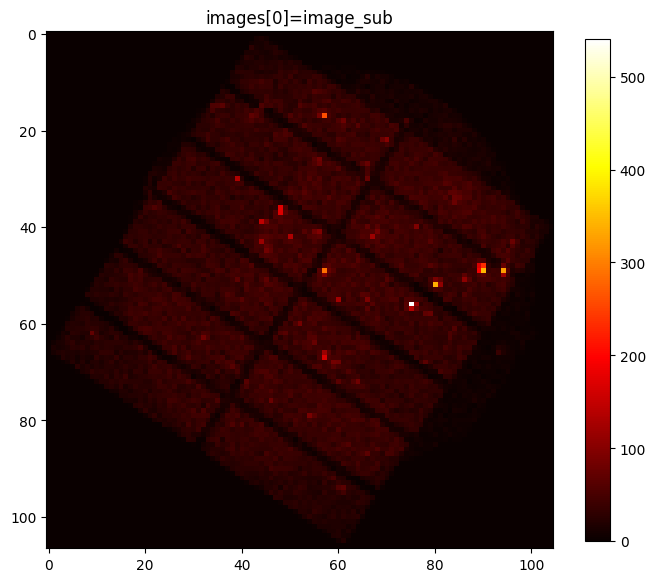

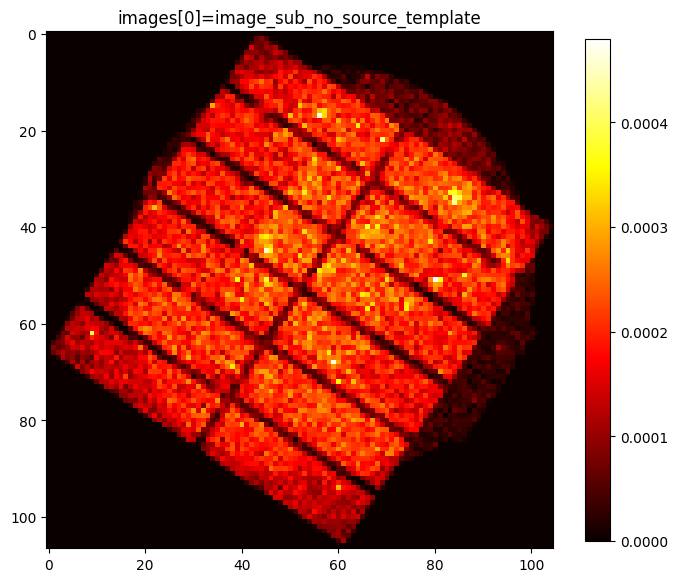

2024-05-21 09:46:25,457 - INFO - 3341376888.py:<module> - Calculating bti template...


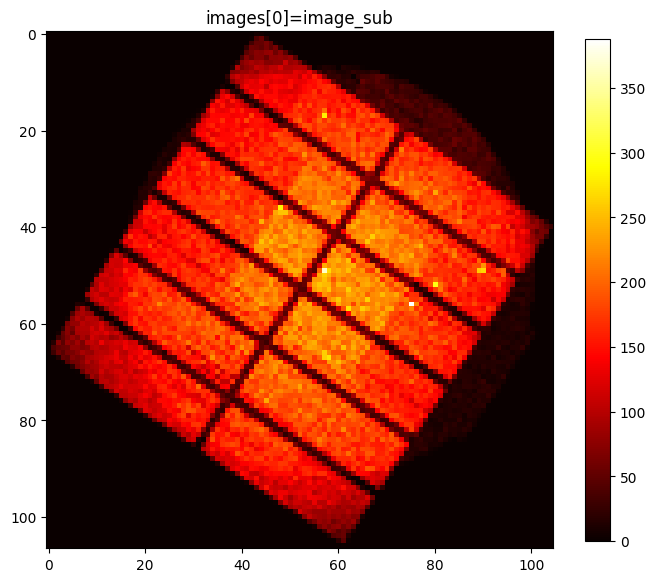

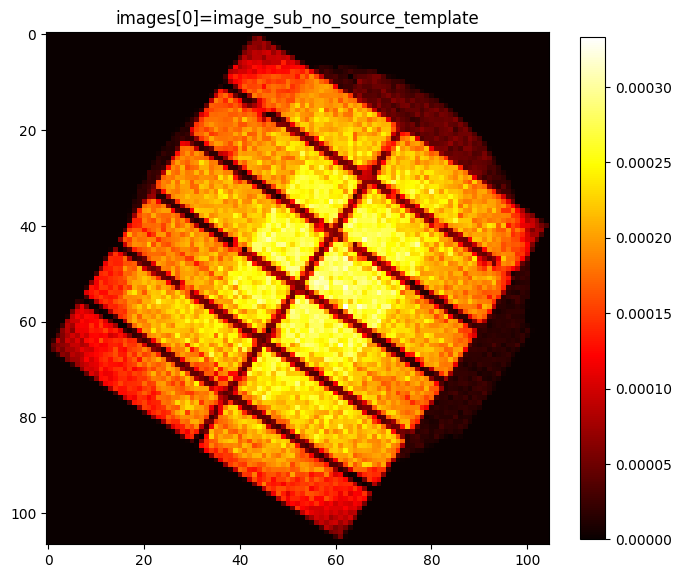

2024-05-21 09:46:26,086 - INFO - 3341376888.py:<module> - Calculating source contribution using gtis
2024-05-21 09:46:26,136 - INFO - 3341376888.py:<module> - Creating expected (mu) cube...
2024-05-21 09:46:26,295 - INFO - 3341376888.py:<module> - Expected cube created!


In [27]:
cube_n = data_cube.data
bti_bin_idx = data_cube.bti_bin_idx
gti_bin_idx = data_cube.gti_bin_idx
n_gti_bin = data_cube.n_gti_bin
n_bti_bin = data_cube.n_bti_bin
cube_gti = cube_n[:, :, gti_bin_idx]
cube_bti = cube_n[:, :, bti_bin_idx]

# Get the summed Images.
image_total = np.nansum(cube_n, axis=2)
image_gti = np.nansum(cube_gti, axis=2)

# Get the summed Images.
image_total = np.nansum(cube_n, axis=2)
image_gti = np.nansum(cube_gti, axis=2)

# Create the source masks.
# Two source masks are calculated then combined, the first comes from the pipeline detected
# sources in the OBSMLI file. The second mask takes the remaining image and masks pixels that are
# above 3 x 75% of the total image. These two masks are then combined using an OR statement.
# This works well in most cases but often struggles when there are extended sources.
image_mask_source_list = mask_known_sources(data_cube, wcs=wcs)  # Image mask from OBSMLI file.
# source_threshold = np.nanpercentile(image_gti.flatten(), 99) # This or from detected sources
source_threshold = 3 * np.nanpercentile(image_gti[~image_mask_source_list], q=75)
image_mask_source_percentile = image_gti > source_threshold
image_mask_source = image_mask_source_list | image_mask_source_percentile

if n_gti_bin:
    logger.info('Calculating gti template...')
    image_gti = np.nansum(cube_gti, axis=2)

    image_sub = image_gti

    sigma_blurring = 0.5
    inpaint_method = INPAINT_NS # INPAINT_TELEA

    image_sub_no_source                       = inpaint(image_sub.astype(np.float32), image_mask_source.astype(np.uint8), inpaintRadius=2, flags=inpaint_method)
    count_sub_outside_sources                 = np.nansum(image_sub[~image_mask_source])
    image_sub_no_source_template              = image_sub_no_source / count_sub_outside_sources
    image_sub_no_source_template_blur         = convolve(image_sub_no_source_template, Gaussian2DKernel(sigma_blurring))
    image_mask_missing_pixels                 = (image_sub > 0) & np.isnan(image_sub_no_source_template_blur)
    image_sub_no_source_template_blur_inpaint = inpaint(image_sub_no_source_template_blur.astype(np.float32), image_mask_missing_pixels.astype(np.uint8), inpaintRadius=2, flags=inpaint_method)
    image_sub_background_template             = np.where(image_sub > 0, image_sub_no_source_template_blur_inpaint, np.nan)
    
    image_gti_background_template, count_gti_outside_sources = calc_background_template(image_sub=image_gti, image_mask_source=image_mask_source)

if n_bti_bin:
    logger.info('Calculating bti template...')
    image_bti = np.nansum(cube_bti, axis=2) # Image of all btis combined, with sources
    image_bti_background_template, count_bti_outside_sources = calc_background_template(image_sub=image_bti, image_mask_source=image_mask_source)

# image_bti_no_source_template_blur=image_bti_no_source_template

# Obtain the Image with the mean source contribution (zero everywhere that is not a source)
if n_gti_bin > n_bti_bin:
    logger.info('Calculating source contribution using gtis')

    image_sub_source_only1   = image_sub - image_sub_background_template * count_sub_outside_sources
    image_sub_source_only2   = np.where(image_mask_source, image_sub_source_only1, 0)           # Replace everything that is not a source with 0
    image_sub_source_only3   = np.where(image_sub_source_only2 > 0, image_sub_source_only2, 0)  # Replace negative values with 0
    effective_exposed_frames = np.sum(data_cube.relative_frame_exposures[gti_bin_idx])       # Analagous to n_gti_bin if relative exposures = 1
    image_source_template    = image_sub_source_only3 / effective_exposed_frames                # Average value of the source contribution per frame.
    

    
    #image_source_template = calc_source_template(image_gti, image_gti_background_template, image_mask_source,
    #                                             data_cube, count_gti_outside_sources, gti_bin_idx)
else:
    logger.info('Calculating source contribution using btis')
    #image_source_template = calc_source_template(image_bti, image_bti_background_template, image_mask_source,
    #                                             data_cube, count_bti_outside_sources, bti_bin_idx)

# Get data cube outside the sources to obtain the background light curve.
cube_mask_source       = np.repeat(image_mask_source[:, :, np.newaxis], cube_n.shape[2], axis=2)
cube_n_outside_sources = np.where(cube_mask_source, np.nan, cube_n)
lc_outside_sources     = np.nansum(cube_n_outside_sources, axis=(0, 1)) # Essentially the background light curve.


logger.info('Creating expected (mu) cube...')
# Create the expectation cube by combining the source and background templates.
cube_mu = np.empty(cube_n.shape)
if n_gti_bin:
    cube_mu[:,:,gti_bin_idx] = image_gti_background_template[:,:,np.newaxis] * lc_outside_sources[gti_bin_idx]
if n_bti_bin:
    cube_mu[:,:,bti_bin_idx] = image_bti_background_template[:,:,np.newaxis] * lc_outside_sources[bti_bin_idx]
cube_mu += image_source_template[:,:,np.newaxis] * data_cube.relative_frame_exposures
cube_mu = np.where(np.nansum(cube_n, axis=(0,1)) > 0, cube_mu, np.nan)
logger.info('Expected cube created!')



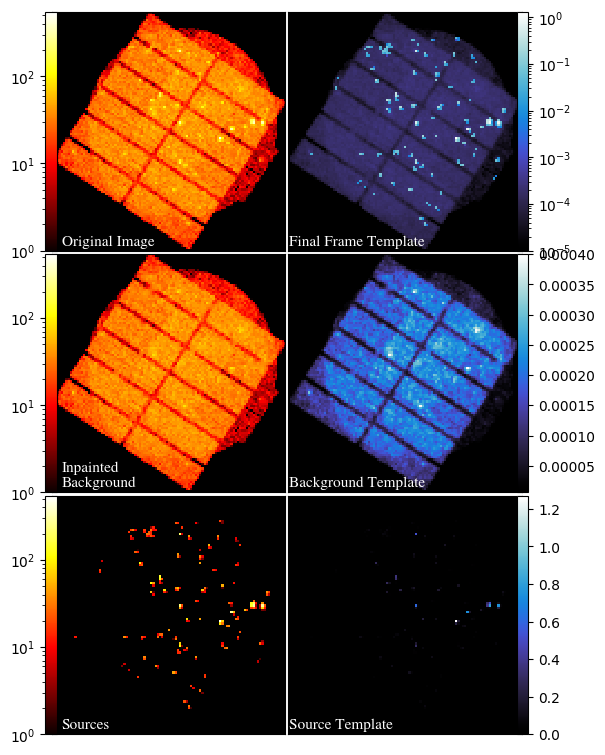

In [65]:
norm = LogNorm(vmin=1, vmax=np.max(image_gti))
fig, ax = plt.subplots(3,2, figsize=(6,9))
im = ax[0][0].imshow(image_gti, cmap=cmap_image(), norm=norm, interpolation='none')

divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes('left', size="5%", pad=-0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('left')  
cax.yaxis.set_label_position('left')

im = ax[1][0].imshow(image_sub_no_source, cmap=cmap_image(), norm=norm, interpolation='none')

divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes('left', size="5%", pad=-0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('left')  
cax.yaxis.set_label_position('left')


im = ax[2][0].imshow(image_sub_source_only2, cmap=cmap_image(), norm=norm, interpolation='none')

divider = make_axes_locatable(ax[2][0])
cax = divider.append_axes('left', size="5%", pad=-0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('left') 
cax.yaxis.set_label_position('left')


c = cmasher.freeze
c.set_bad('black')

im = ax[1][1].imshow(image_gti_background_template, interpolation='none', cmap=c)

divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes('right', size="5%", pad=-0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('right')  
cax.yaxis.set_label_position('right')

im = ax[2][1].imshow(image_source_template, interpolation='none', cmap=c)

divider = make_axes_locatable(ax[2][1])
cax = divider.append_axes('right', size="5%", pad=-0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('right')  
cax.yaxis.set_label_position('right')


image_template_final = np.nansum([image_source_template, image_gti_background_template], axis=0)
im = ax[0][1].imshow(image_template_final, interpolation='none', cmap=c, norm=LogNorm(vmin=1e-5, vmax=np.max(image_template_final)))

divider = make_axes_locatable(ax[0][1])
cax = divider.append_axes('right', size="5%", pad=-0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position('right')  
cax.yaxis.set_label_position('right')





for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
ax[0][0].text(4, 104, 'Original Image', fontdict={'family': 'STIXGeneral', 'color': 'white', 'weight': 'regular', 'size': 11})
ax[1][0].text(4, 104, 'Inpainted\nBackground', fontdict={'family': 'STIXGeneral', 'color': 'white', 'weight': 'regular', 'size': 11})
ax[2][0].text(4, 104, 'Sources', fontdict={'family': 'STIXGeneral', 'color': 'white', 'weight': 'regular', 'size': 11})
ax[0][1].text(0, 104, r'Final Frame Template', fontdict={'family': 'STIXGeneral', 'color': 'white', 'weight': 'regular', 'size': 11})
ax[1][1].text(0, 104, r'Background Template', fontdict={'family': 'STIXGeneral', 'color': 'white', 'weight': 'regular', 'size': 11})
ax[2][1].text(0, 104, r'Source Template', fontdict={'family': 'STIXGeneral', 'color': 'white', 'weight': 'regular', 'size': 11})

plt.tight_layout()
plt.subplots_adjust(hspace=-0.35, wspace=0.01)
plt.savefig('../data/plots/template_creation.png')
plt.savefig('../data/plots/template_creation.pdf')
plt.show()
    

/tmp/ipykernel_655438/1338879072.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(image_template_final.flatten()), bins=np.linspace(-6,0, 100))


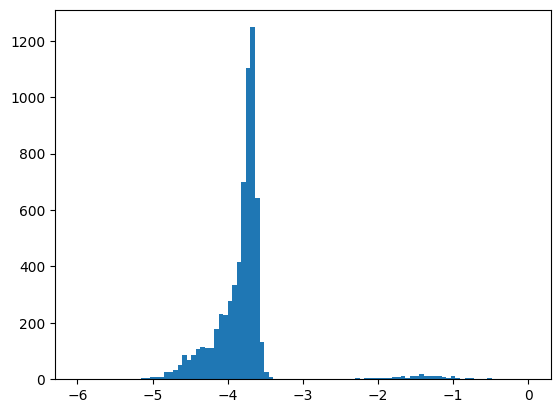

In [52]:
plt.hist(np.log10(image_template_final.flatten()), bins=np.linspace(-6,0, 100))
plt.show()

In [25]:
np.max(image_template_final)

nan

In [20]:
np.nansum([]

SyntaxError: incomplete input (3283420775.py, line 1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)